<a href="https://colab.research.google.com/github/NasifSarwar/Reproducing-Unsupervised-Fake-News-Detector/blob/main/GMM_%2B_GCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q wordcloud mplcursors nltk

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from wordcloud import WordCloud
import mplcursors  # Required for interactive plot

In [6]:
# Read the dataset and add an ID column
news_data = pd.read_table('./news_data.tsv', delimiter='\t')
news_data['id'] = range(len(news_data))
news_data.head()

,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer,id
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,2
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,3
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,4


In [7]:
# Read the dataset and add an ID column
news_data = pd.read_table('./news_data.tsv', delimiter='\t')
news_data['id'] = range(len(news_data))

In [8]:
# Drop unnecessary columns and rename the rest
news_data.drop(columns=['2635.json', 'abortion', 'dwayne-bohac', 'State representative', 'Texas', 'republican', '0', '1', '0.1', '0.2', '0.3', 'a mailer'], inplace=True)
news_data.columns = ['label', 'news_text', 'id']

In [9]:
# Sample equal data points from each class
news_data_half_true_only = news_data[news_data['label'] == 'half-true'].sample(830, random_state=42)
news_data_false_only = news_data[news_data['label'] == 'false'].sample(830, random_state=42)
news_data_mostly_true_only = news_data[news_data['label'] == 'mostly-true'].sample(830, random_state=42)
news_data_true_only = news_data[news_data['label'] == 'true'].sample(830, random_state=42)
news_data_barely_true_only = news_data[news_data['label'] == 'barely-true'].sample(830, random_state=42)
news_data_pants_fire_only = news_data[news_data['label'] == 'pants-fire'].sample(830, random_state=42)

In [10]:
# Concatenate and shuffle the data
news_data = pd.concat([news_data_half_true_only, news_data_false_only, news_data_mostly_true_only, news_data_true_only, news_data_barely_true_only, news_data_pants_fire_only], axis=0)
news_data = news_data.sample(frac=1.0, random_state=42)

In [11]:
news_data.head()

,label,news_text,id
9822,false,Says Russ Feingold voted to give Social Securi...,9822
8580,barely-true,Says Texas proved in court that more than 200 ...,8580
8410,false,Says the New York Times can write a story that...,8410
721,mostly-true,Says in the last six months of the Bush admini...,721
9156,false,A (state) trooper with 10 years on the force i...,9156


In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Preprocessing
nltk.download('stopwords')
nltk.download('punkt')
ps = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [ps.stem(i) for i in text if i.isalnum() and i not in stopwords.words('english')]
    return " ".join(text)

news_data['preprocessed_news_text'] = news_data['news_text'].apply(preprocess_text)

# Save preprocessed data to a new file
news_data.to_csv('preprocessed_news_data.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


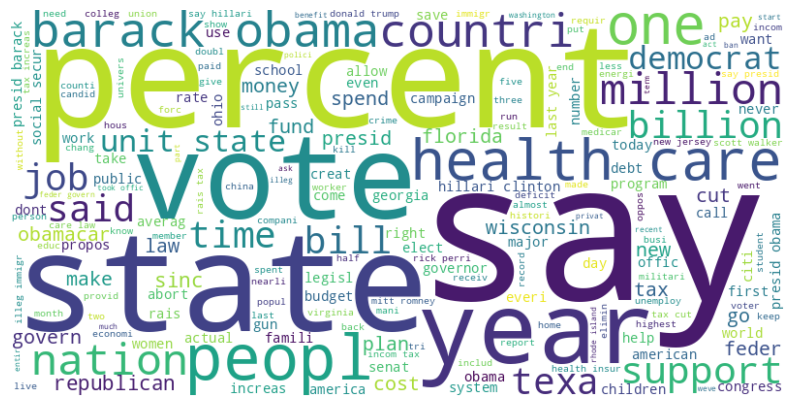

In [15]:
# Generate word cloud
preprocessed_text = ' '.join(news_data['preprocessed_news_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(preprocessed_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.close()  # Close the plot after showing

In [16]:
# Vectorization using Tfidf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(news_data['preprocessed_news_text']).toarray()

In [17]:
# Applying PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

In [18]:
# Scale data for GCO optimization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

In [19]:
# Define GCO-based GMM optimization function
def objective(params):
    n_components = int(params[0])
    reg_covar = params[1]
    max_iter = int(params[2])
    tol = params[3]

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', reg_covar=reg_covar, max_iter=max_iter, tol=tol, random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)

    # Calculate silhouette score as the fitness metric
    return -silhouette_score(X_scaled, labels)

In [20]:
# GCO Algorithm
class GroupCounselingOptimization:
    def __init__(self, func, bounds, num_agents, max_iter):
        self.func = func
        self.bounds = bounds
        self.num_agents = num_agents
        self.max_iter = max_iter
        self.dim = len(bounds)
        self.population = np.random.rand(num_agents, self.dim)
        for i in range(self.dim):
            self.population[:, i] = self.population[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
        self.fitness = np.apply_along_axis(self.func, 1, self.population)

    def optimize(self):
        for iteration in range(self.max_iter):
            for i in range(self.num_agents):
                M = np.mean(self.population, axis=0)
                r = np.random.uniform(-1, 1, self.dim)
                x_new = self.population[i] + r * (self.population[i] - M)
                for j in range(self.dim):
                    if x_new[j] < self.bounds[j][0]:
                        x_new[j] = self.bounds[j][0]
                    elif x_new[j] > self.bounds[j][1]:
                        x_new[j] = self.bounds[j][1]
                new_fitness = self.func(x_new)
                if new_fitness < self.fitness[i]:
                    self.population[i] = x_new
                    self.fitness[i] = new_fitness
        best_index = np.argmin(self.fitness)
        return self.population[best_index], self.fitness[best_index]

In [21]:
# GCO parameters
bounds = [(2, 10), (1e-6, 1e-2), (100, 500), (1e-4, 1e-2)]
num_agents = 5  # Reduced to speed up optimization
max_iter = 20   # Reduced to make optimization faster

In [22]:
# Run GCO to optimize GMM
gco = GroupCounselingOptimization(objective, bounds, num_agents, max_iter)
best_params, best_fitness = gco.optimize()

In [23]:
# Train the final GMM with optimized parameters
n_components = int(best_params[0])
reg_covar = best_params[1]
max_iter = int(best_params[2])
tol = best_params[3]

In [24]:
final_gmm = GaussianMixture(n_components=n_components, covariance_type='full', reg_covar=reg_covar, max_iter=max_iter, tol=tol, random_state=42)
final_gmm.fit(X_scaled)

GaussianMixture(max_iter=332, n_components=3, random_state=42,
                reg_covar=np.float64(0.01),
                tol=np.float64(0.004363581103091724))

In [25]:
# Predict cluster labels
labels = final_gmm.predict(X_scaled)

In [26]:
# Convert true labels to numeric
label_encoder = LabelEncoder()
news_data['numeric_labels'] = label_encoder.fit_transform(news_data['label'])

true_labels = news_data['numeric_labels']
predicted_labels = labels

In [27]:
# Calculate metrics
def purity_score(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

In [28]:
# Metrics for final GMM
inertia = -final_gmm.score(X_scaled)  # Negative log-likelihood approximation for inertia
silhouette = silhouette_score(X_scaled, labels)
accuracy = accuracy_score(true_labels, predicted_labels)
purity = purity_score(true_labels, predicted_labels)
adjusted_rand = adjusted_rand_score(true_labels, predicted_labels)

In [29]:
print("Inertia:", inertia)
print("Silhouette Score:", silhouette)
print("Accuracy:", accuracy)
print("Purity Score:", purity)
print("Adjusted Rand Index:", adjusted_rand)

Inertia: 1.207566967801303
Silhouette Score: 0.7184048934704006
Accuracy: 0.16666666666666666
Purity Score: 0.19056224899598392
Adjusted Rand Index: 0.0017979878886448051


In [30]:
# Metrics for each cluster
clusters = np.unique(labels)
for cluster in clusters:
    cluster_data = X_scaled[labels == cluster]
    cluster_true_labels = true_labels[labels == cluster]
    cluster_predicted_labels = predicted_labels[labels == cluster]

    cluster_silhouette = silhouette_score(cluster_data, cluster_predicted_labels) if len(set(cluster_predicted_labels)) > 1 else None
    cluster_purity = purity_score(cluster_true_labels, cluster_predicted_labels) if len(set(cluster_predicted_labels)) > 1 else None

    print(f"\nCluster {cluster} Metrics:")
    print(f"Silhouette Score: {cluster_silhouette}")
    print(f"Purity Score: {cluster_purity}")


Cluster 0 Metrics:
Silhouette Score: None
Purity Score: None

Cluster 1 Metrics:
Silhouette Score: None
Purity Score: None

Cluster 2 Metrics:
Silhouette Score: None
Purity Score: None


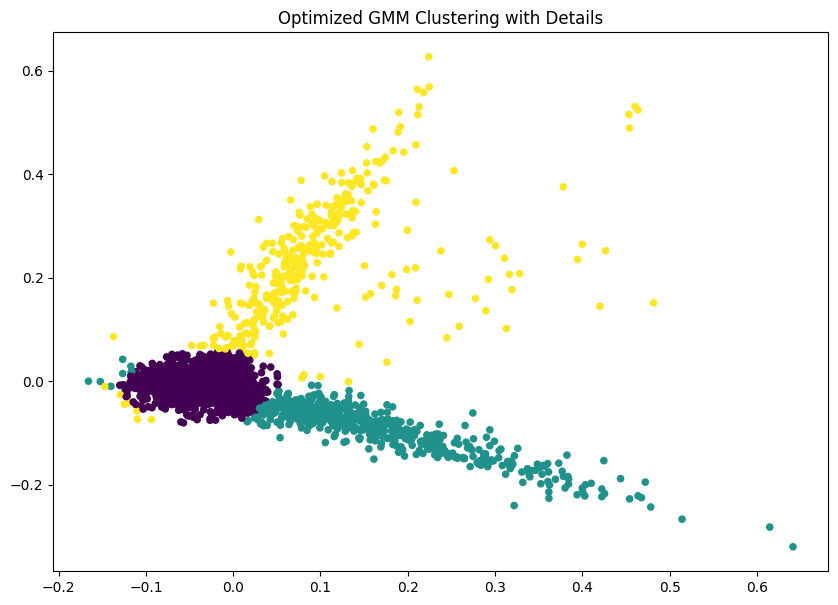

Optimized Parameters from GCO:
Number of components: 3
Regularization on covariance: 0.01
Maximum iterations: 332
Tolerance: 0.004363581103091724


In [31]:
# Visualize the optimized GMM clustering with interactive points
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=20)

# Create a cursor object for interaction
cursor = mplcursors.cursor(scatter, hover=True)

# Function to show label, data, and ID on hover
@cursor.connect("add")
def on_add(sel):
    index = sel.target.index
    label = news_data.iloc[index]['label']  # Get the label from the original dataset
    news_id = news_data.iloc[index]['id']  # Get the ID from the original dataset
    news_text = news_data.iloc[index]['news_text']  # Get the news text from the original dataset
    sel.annotation.set(text=f'ID: {news_id}\nLabel: {label}\nText: {news_text[:100]}...', position=(sel.target[0], sel.target[1]), anncoords="offset points")

# Show the plot with interaction
plt.title('Optimized GMM Clustering with Details')
plt.show()

# Display the optimized parameters
print("Optimized Parameters from GCO:")
print(f"Number of components: {n_components}")
print(f"Regularization on covariance: {reg_covar}")
print(f"Maximum iterations: {max_iter}")
print(f"Tolerance: {tol}")